## NES-LTER: Comparison between CTD and sampled chlorophyll concentration estimates

This notebook combines chlorophyll concentration estimates derived from a CTD-mounted fluoremeter with corresponding estaimates derived from lab processing of samples. This enables confirming that the estimates match, which aids in the decision of when to take samples.

In [1]:
import warnings; warnings.simplefilter('ignore')
from neslter.parsing.chl import parse_chl
from neslter.parsing.ctd.btl import compile_btl_files
from neslter.analysis.chl import average_replicates

In [2]:
import os

DIR = '/home/joefutrelle/data/nes-lter-ims-test-data'
assert os.path.exists(DIR)

Parse Sosik chlorophyll data from samples

In [3]:
chl_path = os.path.join(DIR, 'NESLTERchl.xlsx')
assert os.path.exists(chl_path)

chl = parse_chl(chl_path)
chl.head()

,cruise,cast,niskin,replicate,vol_filtered,filter_size,vol_extracted,sample,ninety_percent_acetone,dilution_during_reading,...,rb,ra,blank,rb_blank,ra_blank,chl,phaeo,cal_date,fluorometer,comments
12,AR22,2,2,a,535.0,0,5.0,1.0,0.0,1.0,...,146.60,95.89,0.493,146.107,95.397,0.483914,0.337237,20180126.0,Aquafluor,a?
22,AR22,2,6,10a,540.0,0,5.0,1.0,0.0,1.0,...,165.00,100.70,0.493,164.507,100.207,0.607918,0.246649,20180126.0,Aquafluor,
29,AR22,3,3,b,535.0,0,5.0,1.0,0.0,1.0,...,88.81,60.01,0.493,88.317,59.517,0.274832,0.237474,20180126.0,Aquafluor,b?
32,AR22,3,5,a,535.0,0,5.0,1.0,0.0,1.0,...,466.10,301.00,0.493,465.607,300.507,1.575510,1.011170,20180126.0,Aquafluor,
48,AR22,4,6,b,540.0,0,5.0,1.0,0.0,1.0,...,175.70,111.30,0.493,175.207,110.807,0.608864,0.336101,20180126.0,Aquafluor,


Now compile parsed .btl files for CTD casts

In [4]:
btl_path = os.path.join(DIR, 'en608_btl')
assert os.path.exists(btl_path)

# parse cruise .btl files containing fluorometer readings
btl = compile_btl_files(btl_path)
btl.head()

,cruise,cast,niskin,date,sal00,sal11,sigma_t00,sigma_t11,oxsatmm_kg,sbox0mm_kg,...,v5,sbeox1v,v6,par,cpar,v7,spar,latitude,longitude,depsm
0,EN608,7,1,2018-02-01 17:37:38,32.8069,32.8044,25.8657,25.8636,308.46080,-81.677,...,0.0026,0.0026,2.2284,118.290,9.2577,0.0,1279.30,40.69006,-71.09536,10.069365
1,EN608,7,2,2018-02-01 17:37:46,32.8068,32.8044,25.8656,25.8637,308.46204,-81.773,...,0.0026,0.0025,2.2288,118.070,8.2300,0.0,1430.60,40.69002,-71.09530,10.192401
2,EN608,7,3,2018-02-01 17:39:49,32.8065,32.8041,25.8658,25.8639,308.49123,-81.733,...,0.0021,0.0021,2.7621,408.470,28.0190,0.0,1460.70,40.68940,-71.09458,4.730123
3,EN608,7,4,2018-02-01 17:39:58,32.8064,32.8039,25.8653,25.8633,308.46408,-81.736,...,0.0021,0.0021,2.8222,469.900,32.2300,0.0,1454.60,40.68934,-71.09452,4.396726
0,EN608,6,1,2018-02-01 13:54:08,32.6173,32.6147,25.8823,25.8802,320.55083,-85.251,...,0.0028,0.0027,1.6743,31.984,7.6749,0.0,416.74,40.69095,-70.65586,10.553570


Samples are replicated, so the chlorophyll concentration needs to be averaged across those replicates.

In [5]:
# average chlorophyll replicates
chl_avg = average_replicates(chl, replicates=['a','b'], over='any')
chl_avg.head()

,cruise,cast,niskin,chl
0,AR22,10,2,0.008355
1,AR22,10,3,0.005878
2,AR22,10,4,0.007625
3,AR22,10,5,0.014061
4,AR22,10,6,0.044388


Now the two datasets need to be collated so that they align on cruise, cast, and niskin bottle number.

In [6]:
# merge sample and CTD data per-niskin
merged = btl.merge(chl_avg, on=['cruise','cast','niskin'])

# display a few rows to make sure we're doing it right
merged[['cruise','cast','niskin','chl','fleco_afl','par']].head()

,cruise,cast,niskin,chl,fleco_afl,par
0,EN608,12,1,1.547147,0.7365,1.000000e-12
1,EN608,12,4,1.515102,0.5994,1.000000e-12
2,EN608,12,8,1.547597,0.7277,1.000000e-12
3,EN608,12,11,1.567008,1.0367,1.000000e-12
4,EN608,12,14,1.653382,0.9775,4.369200e-02


The column containing CTD-derived data is called `fleco_afl` and the one containing the sample-derived data is called `chl`.

Plot them against each other, coloring by PAR:

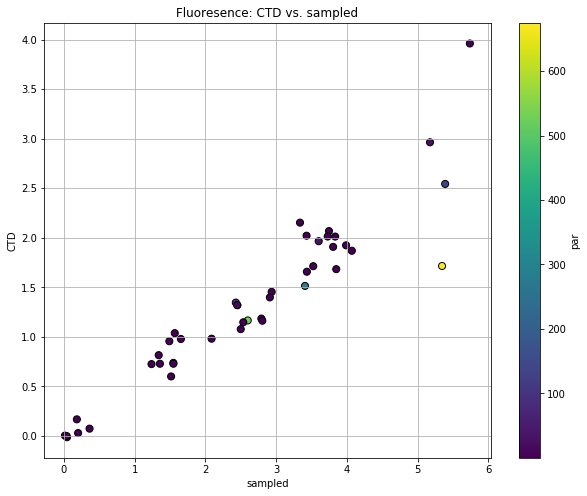

In [7]:
%matplotlib inline

# now plot CTD against sampled data
ax = merged.plot.scatter(
    x='chl',
    y='fleco_afl',
    c='par',
    s=50,
    cmap='viridis',
    edgecolor='black',
    title='Fluoresence: CTD vs. sampled',
    grid=True,
    figsize=(10,8),
    sharex=False
)
ax.set_xlabel('sampled')
ax.set_ylabel('CTD')
None